# 1. Import necessary packages

In [76]:
import matplotlib.pyplot as plt
import plotly.express as px 
import numpy as np
import pandas as pd
import pywt
import plotly.graph_objects as go

# 2. Load data

In [81]:
df = pd.read_csv('output.csv')
df = pd.read_excel('newdata.xlsx')
depth = np.array(df['DEPTH'][7000:])
ac_synt_ml = np.array(df['AC_SYNT_ML'][7000:])
ac_ground_truth = np.array(df['AC'][7000:])
df1 = pd.read_csv('input.csv')
ac_meas = np.array(df['RT_AC'][7000:])

print(ac_meas)

[  106.69677734   106.90034485   107.18649292 ... -9999.
 -9999.         -9999.        ]


# 3. Data cleaning

In [82]:
measurement_present = np.ones(N_meas)

for k in range(1, N_meas):
    if ac_meas[k] < -9990:
        measurement_present[k]=0
        

# 4. Apply Kalman filter 

In [86]:
#Standard Kalman filter with Brownian motion process model
P = np.ones(N_meas)*100
Std = np.zeros(N_meas)
R = 100
Q = 10
x = np.zeros(N_meas)
x[0] = ac_meas[0]
z=np.zeros(N_meas)

for k in range(1, N_meas):

    Q_t=Q*(depth[k]-depth[k-1])
    
    #Prediction step
    P[k] = P[k-1] + Q_t
    x[k]=x[k-1]
    
    if measurement_present[k]:
        #Measurement update
        z[k] = ac_meas[k] - x[k]
        S = P[k] + R
        K = P[k]/S
        x[k]= x[k] + K*z[k]
        P[k]=P[k]-K*S*K
    
    #Store one standard deviation of the covariance
    Std[k]=np.sqrt(P[k])


# 5. Plot the output

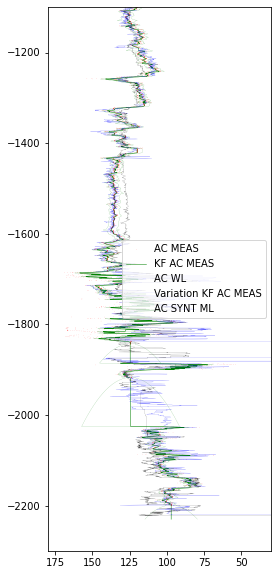

In [87]:
plt.figure(figsize=(4, 10))
plt.scatter(ac_meas, -depth, s=0.1, color='red', edgecolor='none', label='AC MEAS')
plt.plot(x, -depth, color='green', linewidth=0.5, label='KF AC MEAS')
plt.plot(ac_ground_truth, -depth, color='blue', linewidth=0.1, label='AC WL')
plt.plot(x+Std, -depth, color='green', linewidth=0.1, label='Variation KF AC MEAS')
plt.plot(x-Std, -depth, color='green', linewidth=0.1)
plt.plot(ac_synt_ml, -depth, color='black', linewidth=0.1, label='AC SYNT ML')
plt.xlim(30, 180)
plt.ylim(-2300, -1100)
plt.legend()
plt.gca().invert_xaxis()


plt.savefig('plotnewdata.png',format='png', dpi=600)
#plt.show()

In [88]:
import plotly.io as pio

# Create a figure
fig = go.Figure()

# Add the scatter plot for 'AC MEAS'
fig.add_trace(go.Scatter(
    x=ac_meas,
    y=-depth,
    mode='markers',
    marker=dict(size=3, color='red'),
    name='AC MEAS'
))

# Add the line plot for 'KF AC MEAS'
fig.add_trace(go.Scatter(
    x=x,
    y=-depth,
    mode='lines',
    line=dict(color='green', width=2.5),
    name='KF AC MEAS'
))

# Add the line plot for 'AC WL'
fig.add_trace(go.Scatter(
    x=ac_ground_truth,
    y=-depth,
    mode='lines',
    line=dict(color='blue', width=1.5),
    name='AC WL'
))

# Add the line plot for 'Variation KF AC MEAS (x + Std)'
fig.add_trace(go.Scatter(
    x=x + Std,
    y=-depth,
    mode='lines',
    line=dict(color='green', width=1.5),
    name='Variation KF AC MEAS'
))

# Add the line plot for 'Variation KF AC MEAS (x - Std)'
fig.add_trace(go.Scatter(
    x=x - Std,
    y=-depth,
    mode='lines',
    line=dict(color='green', width=1.5),
    showlegend=False  # Avoid showing the label twice in the legend
))

# Add the line plot for 'AC SYNT ML'
fig.add_trace(go.Scatter(
    x=ac_synt_ml,
    y=-depth,
    mode='lines',
    line=dict(color='black', width=1.5),
    name='AC SYNT ML'
))

# Set the x-axis range and invert it
fig.update_layout(
    xaxis=dict(range=[180, 30]),  # Inverted x-axis
    yaxis=dict(range=[-2300, -1100]),
    legend=dict(title='Legend'),
    height=10000,
)

# Show the figure
pio.show(fig, renderer="browser")